In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
#aba ata kaiming init launu paryo forward pass normalize garna lai so
#we are using tanh so
(5/3) / (30**0.5)     #input size 30 hunxa ni ta 10 + 10 + 10
#= 0.304. vanesi yesle multiply garnu paryo w1 lai


# ***sike*****
# Actually this kaiming init for  normalization is not important due to modern invotation
# easy kei hola, teso vaye

# what is that then?

0.3042903097250923

In [ ]:
#batch normalization comes into play
#google research
#idea: if you want your layer to be gussian, then just normalize the layer to make it gussian. simple as that, hehe
#vanesi hamle hpreact lai normalize garnu paryo hoina? yes.
# just do this.
# 1. paile hpreat ko mean nikalne row bata. i.e 1 * 200 hune vayo.
# 2. mathi ko jasari nai standard deviation nikalne row bata nai 1*200 nai vayo.
# 3. now change hpreact to hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=true)  normalize vayo

# yo garepaxi k vayo ta?
# aba hamro tyo batch i.e 32 examples ko sabai 200 neurons ko s.d 1 ko najik hunxa. which is good for network to learn
# so it is called batch normalization. nice

# mathi ko normalization is perfectly differentiable hence backpropagate garna sakne ni vayo ni ta easily. hehe



# -- observations hamle mathi ko normalization ta herek iteration ma garko xa ni ta. meaning we are forcing model to make it's activation gussian
# yesto garda chain khasai ramro learn garena xa.
# k garnu paryo vanda kheri. initialization ma matra normalization garnu paryo.   My idea:  epoch epoch or testai time interval ma normalization garda kasto hola ra?


# vanesi shifting and adding bias comes into play
# introduce bngain as torch.ones((1,n_hidden))
# introdue bnbias as torch.zeros((1,n_hidden))

# now change hpreact to hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=true) + bnbias
# yeti garsi ta first ma unit gussian nai hunxa initialization ma ta
# ani hamle yo formula ta forward pass ma nai rekhxum ni ta so aba model is free to use this to decrease the loss.

# Q. ok first ma ta unit gussian lai gareko ho. aba training hudai garda chai yo change le kasari help garyo hamlai, yo chai exactly bujina maile.
# Q. herek choti normalize ta hunxa tara network le gain ra shift ni garna payo hoina?
# Q. I still think this is some how limiting the network, kinaki normalization ta still gariraxum ni ta hamle.
# -> normalization lai counter garna milxa ta bgain ra bbias le, so farak pardaina ra network ko aafno loss decrease garna jasari ni
# -> parameters twiks garna sakxa, ata tyo fredom xa. (always normaization hunxa vanne xaina ni ta bgain ra bbias vayeko le)

#47:30


# ****************************** But there is some problem in this batch-normalization method ****************************

# 1. we know hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=true) + bnbias
# 2. yo ta forward pass ra backward pass dubai ma aauxa sure
# 3. aba euta example ko activation nikanla batch ko sabai example ko use hune vayo ni ta, right? kina ki, hpreact.mean  ra hpreact.std garda ta sabai use hunxa
#    ni ta
# 4. this is terrifying scientists.
# 5. But it turns out yesle khasai hamper garne rainxa, yesle chai regulariser jasari use hune raixa

# is there any normalization jasma chai yo problem hudain?


# another problem, aba hamle next char kasari predict garne ra?
# kina ki ata ta forward pass ma ta hpreact ta use garnai parxa, ani hpreact ma ta .mean() use vako xa jasko lagi batch chainxa.
# k garne vanda global mean ra global std deviation use garne

# -> (yo different block of code ma ni nikalna milyo, tara running ma ni nikalnu milne raixa, k k garera.)

# aba yo ta constant jasto vayo ni ta variable ta vayena ni ta.

# Q1. yo global mean ra global standard deviation training phase ma use garna milxa?
# Q2. yo use garda kei hamper hunna ra? yeslai sochnu parla ali yar



In [ ]:
# resnet - yo chai image classification ma kaam aauxa, image input hunxa ra blocks of neural network hunxa, ra output ma chai image classification hunxa
# yo bock haru lai chain bottelneck block vanne raixa.
# yesko implementation github ma easily pauxa so take a look at it.

tensor(0.0160) tensor(0.9969)
tensor(-0.0012) tensor(0.9855)


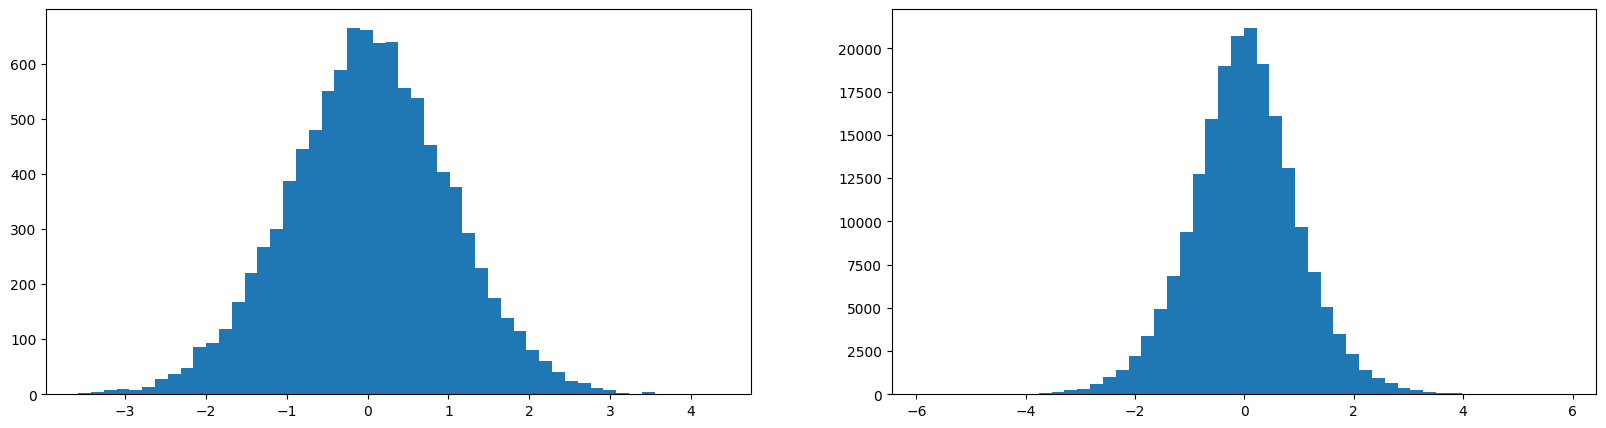

In [ ]:
x = torch.randn(1000,10) #1000*10
w = torch.randn(10,200) * (1/10**0.5)#10*200

print(x.mean(),x.std())   #ok yo random le normal distribution dine raixa ni ta

y = x @ w
print(y.mean(),y.std())    #ok yesko mean ni zero ma nai aaune raixa, tara standard deviation chai ali 1 vanda thulo hune raixa.

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50);

In [ ]:
#  ata we can see, y = x @ w # + b.  yesto garepaxi ta s.d increase hune raixa hoina 1 bata ali badi like 3.
# andrej le vaneko activation haru ko s.d 1 ko oripari vayko ramro re. why?
# hamro y ni ta activation ta ho ni ata. so yeslai k garne?
# can we manupulate w to get the result?
# -yes w lai ni manupulate garne raixa, tara, w lai jasti 0.1 yesto haru le multiply garda information loss hunna?

# hame w lai large number le multiply garda y ko s.d ekdam thulo hune raixa, sano le garda sano hune raixa.

# w ma kati le multiply garne? jasle chai s.d takkai 1 layeos?
# w lai sqrt of (row) le garda hune raixa.

# yo chain activation funtion anusar ni hune raixa. jun chai euta research paper le lekheko xa.
# tesma k vaneko xa vanda kheri hamle forward pass ni normalzie garna sakyo backward pass ni normalize garna sakyo.
# tara it don't matters actually kina ki forward normalize vayepaxi backward ni normalize hune raixa.

# relu xa vane root 2/ root 10 garnu parxa. kina root 2 ? kina ki relu le negative ko ta sabai squacch gardninxa ni ta so * 2 gareko
# testai tanh ma chai 5/3 le multiply hune raixa. same reson. squash garxa ni ta. so weights lai boost deko.

# we call it gain, gain = 1, root 2 , 5.3 and so on aru ko ni.
# yo ramro sanga bujeko xaina
# 1. initialzation ma sabai activations hau normalize nai kina huna parne?
# 2. forward pass normalize vayepaxi backward pass ni kasari normalize hunxa?
# 3. yo gain haru actually nai ati vanera kasari thapa ko?

# pytorch ma xa kaiming init vaera yesko lagi

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation,   batch normalization ma nai bias xa ni ta so we don't use bias here.
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [ ]:
#global mean ra sd nikalna (running ma hoina)
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

NameError: name 'b1' is not defined

In [ ]:
# hamro paile nai initialization ma nai ekdam thulo loss aayo ni ta, aba yeslai k ganre?
# b2 lai zero banaune ani w2 lai ni zero ko close ma lane. yeso vayepaxi logits sabai eqauali i.e 1 hunxa ra loss kam aauxa
# hamle paile nai yesari initialize garepaxi graph herda testo paile ko jasto first ma nai rapidly decrease hunthyo ni ta ho

# tyo chai hudaina. thorai decrease vayejasto hunxa, tara same or better error aauxa paile ko vanda chain.
# yesle k bujayo vanda paile parameters harulai zero tira squash garne raixa loss funtion le which is the easy part. tesaile loss ekdam rapidly decrease
# vayeko jasto dekhinxa. now aba actually training hunxa ni platue jasto ma aaepaxi.

# ok this problem is solved. but we have the problem in h.
# 1. what is the problem?
# 2. why this is affecting the loss
# 3. what is the solution

# 13:50



In [ ]:
h.shape

torch.Size([32, 200])

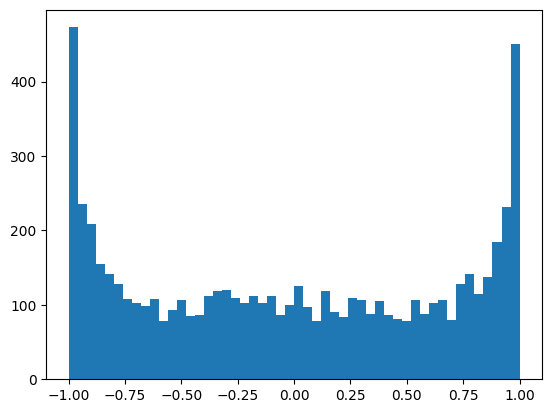

In [ ]:
plt.hist(h.view(-1).tolist(),50);

In [ ]:
#oh here we see most of the values because -1 or +1 when we do tanh. hence i think here we loss many information. because
#2 is also converted 1 and 1000 is also coverted to 1. but they shouldn't have same contribution for forward pass off-course.
# backward propagation ma (1 - t^2) * out.grad hunxa ni ta. no aba t = 1 vaye ta zero vayo ni ta. so loss ma ni kei contribute garena

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50);

In [ ]:
#tanh nagardai ta dami xani ta. tara tanh garesi katti information loss vayo hai?

In [ ]:
# now what is the solution? here?


In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
#true xa vane white aauxa. 32 ota example ma nai herum hai ta kata kata chai > 0.99 aauxa, i.e flat region ma parxa

In [ ]:
# #ekdam badi thaun ma >0.99 xa.  vanesi yetro thaun gradient distroyed hunxa.
# #same case for other activation functions like sigmoid, tanh, reLU etc.
# relu ma yesto pani huna sakxa jastai training garda gardai activation function zero vayo relu le garda, now aba learn ta gardaina yesle
# aba sabai training example harule ni teslai active nabaune sakxa. which indicates it is a dead neuron.
# But why is this issue? I claim is that is a dead neuron then it is not important to decrease the loss. (I may be wrong, no i am 100% wrong, but don't know why)

In [ ]:
#My solution. let's squash the above figure between -1 and 1.
# i.e change hpreact offcourse.

In [ ]:
#Andrej le W1 lai 0.1 ma change garyo ani hpreact ta -1 to 1 ko range ma aayo ta how?
# paile ta yo sabai graphs haru initialization ko bela ko ho. hamle initialization ma nai ramro garum na ani learn ramro sanga huna sakxa vanne ho
# so W1 lai 0.1 garepaxi ta. 200 activation haru -1 to 1 ma nai aauxa because *0.1 gareasi sano hunxa ni ta.
# praye chai -1 to 1 ma nai aauxa.

In [ ]:
#ok white nai xaina ta. tara thorai ta aauna parne hoina ra?

In [ ]:
# # loss log
# # original:
# train 2.124
# val 2.16

# #fix softmax confidently wrong(first ma ta sabai ko probability same hunu parthyo ni ta)
# train 2.09
# val 2.102

# #fix tanh layer too saturated at init:
# train 2.0355
# val 2.1026

In [ ]:
#hamro yo ta ekdam sano neural network ho ni ta, so initialzation ma hamle khasai focus nagare ni learn garyo network le thikai
#but this is not the case when the network is super large.
#so this is very imp

In [ ]:
# ********Summary + pytorchyfying********
# batch normalization are not good, so try to avoid them.
# group normalization, layer normalization are good.




In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5     # harek input ko each output ko lagi weights chaiyo ni ta.
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# Q. yo fan_in ** 0.5 kina gareko re?
# -> yo s.d 1 ra mean zero banauna hoina? kamit initialization
# self.out += self.bias xa, easy.  bias add gareko ta honi
# .paremeters call garda array ma wights ra bias bharera dinxa


# batch normalization ma k k xa ta?
# easy kunai layer lai batch norm, i.e normalize garera pathauxa. easy

# self.out (batch norm ko) ma chain normalize garisakepaxi ko layers ko activation haru raixa hoina? yes

# yo return [self.gamma, self.beta]  yo return chain kina gareko? batch norm ko parameters ho yeni haru?


# Linear(100,200), yo vanna le k bujne? 100 activations connected vako xa 200 activations ma, different layers ko? yes

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [ ]:
# Q. yo -1 to 1 vaneko ta layers ko activation hola hoina,
# ani yo y axix ma chain k ho ra? is the specify how many activation are there with specific activations. tara yo ta feri 0.2, 0.4 haru ma xa. tei nai ho.
# Q. ani yo upward C jasto graph kina aayo ra? how is this good?
# Q. yo saturated vaneko kati chai > 1 or < -1 xa vanera hoina?


# hamle mathi sabai layer haru lai gain le multiply gareko xani i.e 5/3 le.
# if hamle 1 le multiply gareko vaye, yo mathi ko graph farak aauthyo. upward C vanda ni downward C, jasto hunthyo
# i.e sabai activation haru zero ko najik aauthyo
# Q. yesto kina hola ra?
# -> *1 garesi ta *5/3 gareko vanda saturation kam aaula.
# -> originally chai zero ko najik jane tendency hunxa hola, tei vayera hamle (5/3 i.e >1) le multiply gareko.  -- my ans may be wrong

# ---->linear layer lai ta hamle tanh garxum ni ta, but tanh le chai zero ko najik squach garne raixa
# so hamle every time gain le multiply garnu paryo tyo hatauna  (nice by andrej)



# so aba hamle ekdam thulo number le multiply garyo vane like 10. saturation ekdam badxa, offcourse


In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [ ]:
# Q. what the fuck is this?
# yo every layer ko neurons ko gradient ko histogram ho yo. (nice)
# lau gradient ko mean kasari zero vayo ra? wtf? ki maile ulto bujeko?

# ani gradient zero bako badi xa ta. vanesi kasari learn garne ra? learning slow vayena ra?
# ani yo saba layer ko gradient ko graph kasari same aauxa ra?   I am understanding something wrong here

In [ ]:
Investing the graphs if there is  no tanh unit on the linear layers

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

In [ ]:
print([1,2,3] + [4,5,6])